In [59]:
import cifar_gpu_fun
reload(cifar_gpu_fun)
from cifar_gpu_fun import *
import gc
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Define Some Constants 

In [2]:
NUM_FEATURE_BATCHES=1
DATA_BATCH_SIZE=(1280)
FEATURE_BATCH_SIZE=(1024)
NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_CLASSES = 10
POOL_TYPE ='avg'
FILTER_GEN ='empirical'
BANDWIDTH = 1.0
LAMBDAS = [1e-1/FEATURE_BATCH_SIZE, 1e-2/FEATURE_BATCH_SIZE, 1e-3/FEATURE_BATCH_SIZE, 1e-4/FEATURE_BATCH_SIZE, 1e-5/FEATURE_BATCH_SIZE]
CUDA_CONVNET = True
SCALE = 55.0
BIAS = 1.25
MIN_VAR_TOL = 1e-4
TOT_FEAT = FEATURE_BATCH_SIZE*NUM_FEATURE_BATCHES

In [3]:
np.random.seed(10)                                                                                                                                                                   
(XTrain, labelsTrain), (XTest, labelsTest) = load_cifar_processed()
if FILTER_GEN == 'gaussian':
    filter_gen = make_gaussian_filter_gen(1.0)
elif FILTER_GEN == 'empirical':
    patches = patchify_all_imgs(XTrain, (6,6), pad=False)
    filter_gen = make_empirical_filter_gen(patches, labelsTrain, MIN_VAR_TOL)
elif FILTER_GEN == 'empirical_balanced':
    patches = patchify_all_imgs(XTrain, (6,6), pad=False)
    filter_gen = make_balanced_empirical_filter_gen(patches, labelsTrain)
elif FILTER_GEN == 'gaussian_cov':
    patches = patchify_all_imgs(XTrain, (6,6), pad=False)
    filter_gen = make_gaussian_cov_filter_gen(patches)
elif FILTER_GEN == 'gaussian_cc_cov':
    patches = patchify_all_imgs(XTrain, (6,6), pad=False)
    filter_gen = make_gaussian_cc_cov_filter_gen(patches, labelsTrain)
else:
    raise Exception('Unknown FILTER_GEN value')

(50000, 3, 32, 32)


In [5]:
filter_gen

<function cifar_gpu_fun.empirical_filter_gen>

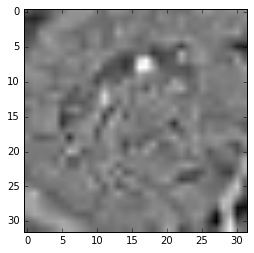

In [6]:
imshow(XTrain[0].transpose(1,2,0)[:,:,0], cmap=pyplot.cm.gray)

In [39]:
X = np.vstack((XTrain, XTest))
(Xlevel1, filters) = conv(X, filter_gen, 1024, 1, 500, CUDA_CONVNET, pool_size=2, symmetric_relu=True)

Out Shape  14 x 14 x 2048
FEATURE BATCH # 0 DATA BATCH # 0  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 1  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 2  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 3  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 4  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 5  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 6  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 7  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 8  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 9  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 10  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 11  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 12  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 13  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 14  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 15  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 16  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 17  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 18  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 19  SIZE IS  500
FEATURE BATCH # 0 DATA B

In [42]:
idxs = np.random.choice(NUM_TRAIN, 1000)

In [43]:
patches_level2 = patchify_all_imgs(Xlevel1[idxs], (2,2), pad=False)

(1000, 2048, 14, 14)


In [44]:
patches_level2 = patches_level2.reshape(patches_level2.shape[0]*patches_level2.shape[1], -1)

In [45]:
bw = estimate_bandwidth(patches_level2)

In [48]:
filter_gen2 = make_gaussian_filter_gen(bw, patch_size=2, channels=2048)


In [61]:
(Xlevel2, filters2) = conv(Xlevel1, filter_gen2, 1024,1, 500, CUDA_CONVNET, pool_size=7, symmetric_relu=True)

Out Shape  2 x 2 x 2048
(1024, 2048, 2, 2)
FEATURE BATCH # 0 DATA BATCH # 0  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 1  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 2  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 3  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 4  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 5  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 6  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 7  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 8  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 9  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 10  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 11  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 12  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 13  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 14  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 15  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 16  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 17  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 18  SIZE IS  500
FEATURE BATCH # 0 DATA BATCH # 19  SIZE IS  500
FEATURE

In [63]:
XFinal = Xlevel2

In [64]:
XFinalTrain = XFinal[:50000,:,:,:].reshape(NUM_TRAIN,-1)
XFinalTest = XFinal[50000:,:,:,:].reshape(NUM_TEST,-1)
print "Output train data shape ", XFinalTrain.shape
print "Output test data shape ", XFinalTest.shape
print "Output filters shape ", filters.shape
convTrainAcc, convTestAcc = trainAndEvaluatePrimalModel(XFinalTrain, XFinalTest, labelsTrain, labelsTest, reg=0)
print "(conv) train: ", convTrainAcc, "(conv) test: ", convTestAcc

Output train data shape  (50000, 8192)
Output test data shape  (10000, 8192)
Output filters shape  (3, 6, 6, 1024)
X SHAPE  (50000, 8192)
Computing XTX
Done Computing XTX
REG is 0
Learning Primal Model
CONFUSION MATRIX
[[781  27  32  19  13   8   8  11  65  36]
 [ 15 854   9   9   5   5   5   4  20  74]
 [ 66  13 613  57  73  55  60  32  17  14]
 [ 23  14  52 559  52 164  52  37  18  29]
 [ 13  13  46  56 680  21  67  76  19   9]
 [ 17   5  45 131  50 659  27  37  13  16]
 [  7  10  35  45  34  28 812  13   5  11]
 [ 11   6  24  33  49  61   8 785  10  13]
 [ 41  26  12  12   5   8   6   9 850  31]
 [ 26  71   5  12   6   9   8   6  24 833]]
(conv) train:  0.89468 (conv) test:  0.7426


In [26]:
filter_gen

<function cifar_gpu_fun.empirical_filter_gen>

In [17]:
Xlevel2.shape

(60000, 800, 2, 2)

In [40]:
Xlevel1.shape

(60000, 2048, 14, 14)

In [15]:
filter_gen2

<function cifar_gpu_fun.gaussian_filter_gen>

In [62]:
Xlevel2.shape

(60000, 2048, 2, 2)

In [8]:
gc.collect()

8872

In [9]:
import theano

In [49]:
bw


159.57294

In [52]:
Xlevel1.shape

(60000, 2048, 14, 14)

In [54]:
2048*14*14

401408

In [58]:
gc.collect()

92405